<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 5: Prediction of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

## Check PyCaret Version

In [1]:
from pycaret.utils import version
version()

'2.3.10'

#### Libraries

In [2]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [3]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

###### Declare some global variables

In [4]:
#Input Data
dir_name = r'C:\Users\kswaminathan\OneDrive\03_Github_Projects\SPE210769_ML_RF_Workflow'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\1_TORIS_MODEL'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\2_GOM_MODEL'
#dir_name = r'C:\Users\quant\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#dfblind = pd.read_excel("BlindTest_SSOIL_NEW.xlsx", sheet_name='Inputs', thousands=',', skiprows = skiprows)
dfblind = pd.read_excel("BlindTest_BOEMGOM.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind_ori = dfblind.copy()
#dfblind.drop('307_Recovery factor (ultimate oil) (%)', axis=1, inplace=True)
#dfblind.dropna(axis = 0, inplace=True)

dfblind.head(10)

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF,RPT_SS,RPT_TI
0,MUU,6491880,7791,13.07,1040,DEP,0.31,0.20,852,3669,173.33,575,30,1.294,0.35,7791,170.545796
1,MUU,6612660,7511,23.63,633,WTR,0.26,0.33,165,3538,171.33,567,31,1.237,0.40,7511,168.893533
2,MUU,1796305,7925,14.12,380,WTR,0.26,0.27,252,5238,173.33,917,31,1.480,0.33,7925,171.336522
3,MUU,924752,10751,11.96,257,PAR,0.26,0.28,142,7315,203.33,1191,36,1.564,0.32,10751,188.012580
4,MUU,89593809,11783,74.66,3021,PAR,0.27,0.21,365,8653,220.33,1624,33,1.763,0.42,11783,194.102350
5,MUU,16823321,9914,12.86,2929,PAR,0.26,0.33,94,7282,196.33,700,30,1.342,0.44,9914,183.073493
6,MUU,15228649,11466,19.17,1488,PAR,0.27,0.22,363,8420,217.33,599,25,1.241,0.43,11466,192.231752
7,MLU,4540933,9066,14.68,796,WTR,0.29,0.25,312,4086,192.33,1000,36,1.310,0.30,9066,178.069495
8,PU,93856,10425,5.57,44,WTR,0.30,0.20,795,7417,165.33,1235,32,1.620,0.33,10425,186.088873
9,MMM,14613315,10006,37.30,14335,DEP,0.29,0.29,212,7559,225.33,1491,34,1.733,0.20,10006,183.616379


## Load the Model

In [6]:
from pycaret.regression import load_model
from pycaret.regression import predict_model

from functools import reduce

final_rf = load_model('Rf_GOM_15072022')
final_stack = load_model('Stacked_model_GOM_15072022')
final_bagged = load_model('Bagged_CB_GOM_15072022')
final_cb = load_model('CatBoost_GOM_15072022')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [7]:
print(final_rf)

Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='regression', target='ORF')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',
                                                    target='ORF...
                 Outlier(contamination=0.05, methods=['pca'], target='ORF')),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='ORF')),
                ('fix_perfect', Remove_100(target='ORF')),
                ('clean_names', Clean_Colum_Names()),
        

In [8]:
BlindPredict1 = predict_model(final_cb, data=dfblind, round=2)
BlindPredict2 = predict_model(final_bagged, data=dfblind, round=2)
BlindPredict3 = predict_model(final_rf, data=dfblind, round=2)
BlindPredict4 = predict_model(final_stack, data=dfblind, round=2)

BlindPredict1 = BlindPredict1.rename(columns={'Label': 'CatBoost Regressor ORF (V/V)'
                                 })
BlindPredict2 = BlindPredict2.rename(columns={'Label': 'Bagged CB Regressor ORF (V/V)'
                                 })
BlindPredict3 = BlindPredict3.rename(columns={'Label': 'Random Forest ORF (V/V)'
                                 })
BlindPredict4 = BlindPredict4.rename(columns={'Label': 'Stack Regressor ORF (V/V)'
                                 })

BlindPredict_df = [BlindPredict1, BlindPredict2, BlindPredict3, BlindPredict4]

BlindPredict = pd.concat(BlindPredict_df, axis = 0, join = 'outer').drop_duplicates()
BlindPredict = BlindPredict.reset_index(drop=True)

BlindPredict

,CHRONOZONE,Original Oil,SS,THK,TAREA,DRIVE,POROSITY,SW,PERMEABILITY,Pi,TI,RSI,API,BOI,ORF,RPT_SS,RPT_TI,CatBoost Regressor ORF (V/V),Bagged CB Regressor ORF (V/V),Random Forest ORF (V/V),Stack Regressor ORF (V/V)
0,MUU,6491880,7791,13.07,1040,DEP,0.31,0.20,852,3669,173.33,575,30,1.294,0.35,7791,170.545796,0.344063,NaN,NaN,NaN
1,MUU,6612660,7511,23.63,633,WTR,0.26,0.33,165,3538,171.33,567,31,1.237,0.40,7511,168.893533,0.391271,NaN,NaN,NaN
2,MUU,1796305,7925,14.12,380,WTR,0.26,0.27,252,5238,173.33,917,31,1.480,0.33,7925,171.336522,0.374458,NaN,NaN,NaN
3,MUU,924752,10751,11.96,257,PAR,0.26,0.28,142,7315,203.33,1191,36,1.564,0.32,10751,188.012580,0.400866,NaN,NaN,NaN
4,MUU,89593809,11783,74.66,3021,PAR,0.27,0.21,365,8653,220.33,1624,33,1.763,0.42,11783,194.102350,0.436335,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,PLL,248701,7044,15.67,36,PAR,0.25,0.18,397,5397,172.33,1189,34,1.623,0.45,7044,166.137794,NaN,NaN,NaN,0.3743
3240,MMM,2021622,21300,15.91,752,WTR,0.22,0.16,537,13924,194.33,1171,32,1.503,0.18,21300,250.261601,NaN,NaN,NaN,0.2147
3241,MUM,20619359,10315,49.82,1234,COM,0.28,0.23,410,5585,153.33,1396,30,1.785,0.36,10315,185.439770,NaN,NaN,NaN,0.3568
3242,PL,1386360,15271,45.15,41,WTR,0.30,0.17,946,11850,221.33,747,18,1.238,0.48,15271,214.684831,NaN,NaN,NaN,0.4243


In [9]:
aggregation_functions = {
    'CatBoost Regressor ORF (V/V)': 'sum', 
    'Bagged CB Regressor ORF (V/V)': 'sum',
    'Random Forest ORF (V/V)': 'sum',
    'Stack Regressor ORF (V/V)': 'sum',
}

labels = dfblind.columns.tolist()

BlindPredict_new = BlindPredict.groupby(labels).aggregate(aggregation_functions)

file_out(BlindPredict, dir_name, 'Blind_Test_Out' , filename_suffix)

BlindPredict_new

Final File Extract Produced


CatBoost Regressor ORF (V/V)  \
CHRONOZONE Original Oil SS    THK   TAREA DRIVE POROSITY SW   PERMEABILITY Pi    TI     RSI  API BOI   ORF  RPT_SS RPT_TI                                     
MLL        918051       8359  11.24 1140  PAR   0.27     0.44 52           3918  174.33 848  36  1.418 0.45 8359   173.897530                      0.187012   
           4138750      9761  32.30 3402  DEP   0.28     0.26 292          5715  226.33 1190 36  1.600 0.17 9761   182.170649                      0.234907   
MLM        82838        9283  28.22 65    PAR   0.29     0.32 156          4378  205.33 800  30  1.390 0.04 9283   179.349999                      0.083453   
           479755       5747  20.17 89    PAR   0.26     0.36 78           2716  149.33 2250 35  1.302 0.27 5747   158.484274                      0.298548   
           509272       25661 37.60 350   PAR   0.24     0.24 67           18594 277.33 1544 37  1.604 0.04 25661  275.995602                      0.138316   
...                                                                                                                                                     ...   
PU         17844414     11182 59.72 746   COM   0.28     0.21 418          6176  210.33 1129 35  1.667 0.48 11182  190.555885                      0.457464   
           18437674     7608  63.60 1355  DEP   0.26     0.17 685          3903  128.33 816  35  1.422 0.18 7608   169.465924                      0.222128   
           23131837     8192  25.07 3216  COM   0.30     0.19 884          5602  177.33 1133 35  1.526 0.39 8192   172.912073                      0.414208   
           24379583     6655  27.18 1856  COM   0.29     0.27 485          3542  167.33 645  41  1.331 0.49 6655   163.842328                      0.457932   
           42605620     12761 46.37 1683  PAR   0.30     0.26 322          8476  149.33 1027 28  1.432 0.45 12761  199.873470                      0.393350   

                                                                                                                               Bagged CB Regressor ORF (V/V)  \
CHRONOZONE Original Oil SS    THK   TAREA DRIVE POROSITY SW   PERMEABILITY Pi    TI     RSI  API BOI   ORF  RPT_SS RPT_TI                                      
MLL        918051       8359  11.24 1140  PAR   0.27     0.44 52           3918  174.33 848  36  1.418 0.45 8359   173.897530                       0.207822   
           4138750      9761  32.30 3402  DEP   0.28     0.26 292          5715  226.33 1190 36  1.600 0.17 9761   182.170649                       0.244559   
MLM        82838        9283  28.22 65    PAR   0.29     0.32 156          4378  205.33 800  30  1.390 0.04 9283   179.349999                       0.091751   
           479755       5747  20.17 89    PAR   0.26     0.36 78           2716  149.33 2250 35  1.302 0.27 5747   158.484274                       0.311430   
           509272       25661 37.60 350   PAR   0.24     0.24 67           18594 277.33 1544 37  1.604 0.04 25661  275.995602                       0.156188   
...                                                                                                                                                      ...   
PU         17844414     11182 59.72 746   COM   0.28     0.21 418          6176  210.33 1129 35  1.667 0.48 11182  190.555885                       0.446999   
           18437674     7608  63.60 1355  DEP   0.26     0.17 685          3903  128.33 816  35  1.422 0.18 7608   169.465924                       0.231572   
           23131837     8192  25.07 3216  COM   0.30     0.19 884          5602  177.33 1133 35  1.526 0.39 8192   172.912073                       0.411032   
           24379583     6655  27.18 1856  COM   0.29     0.27 485          3542  167.33 645  41  1.331 0.49 6655   163.842328                       0.446900   
           42605620     12761 46.37 1683  PAR   0.30     0.26 322          8476  149.33 1027 28  1.432 0.45 12761  199.873470              

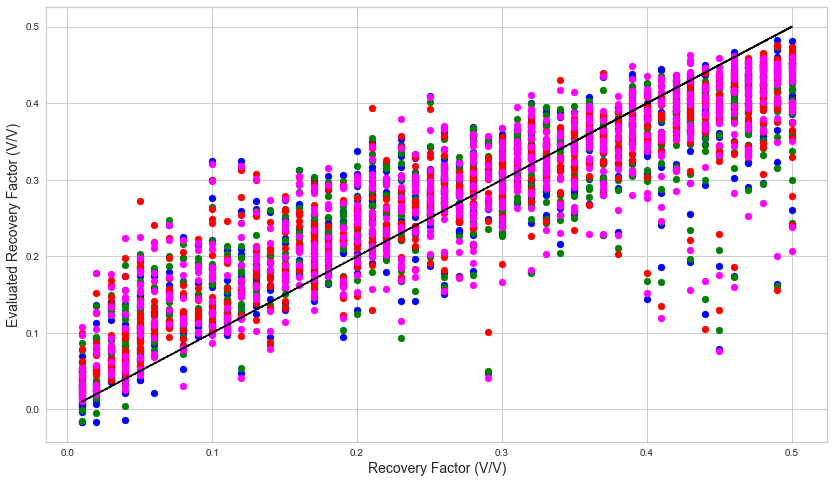

In [10]:
a = BlindPredict['ORF']
b = BlindPredict['CatBoost Regressor ORF (V/V)']
c = BlindPredict['Bagged CB Regressor ORF (V/V)']
d = BlindPredict['Random Forest ORF (V/V)']
e = BlindPredict['Stack Regressor ORF (V/V)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.scatter(a, c, color='green')
plt.scatter(a, d, color='red')
plt.scatter(a, e, color='magenta')
plt.plot(a, a, color = 'black', ls = '--', label = 'x=y')
plt.xlabel("Recovery Factor (V/V)", size=14)
plt.ylabel("Evaluated Recovery Factor (V/V)", size=14)

#plt.tight_layout()
plt.show()

In [11]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 33.595930337905884 seconds
